# Simulation Study

The goal of this simulation study is to study effect of 
1. repulsion strength parameter τ, 
2. upper bound on the number of components K,
3. sample size n, on the behaviour and performance of repulsive Gaussian Mixture Models (RGMMs)

### Step 1: Simulate data from Eqn (20) & Standardize the data

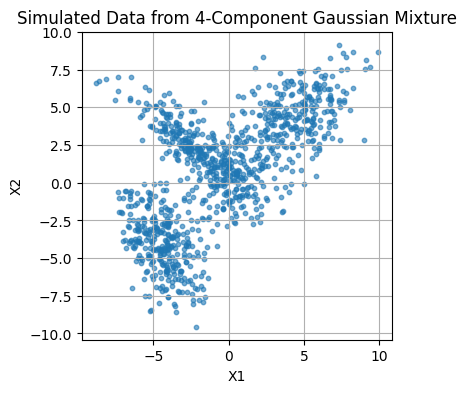

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Random seed for reproducibility
np.random.seed(42)

# Component weights
weights = [0.2, 0.3, 0.3, 0.2]

# Component means
means = [
    np.array([0, 0]),
    np.array([4.5, 4.5]),
    np.array([-4.5, -4.5]),
    np.array([-3, 3])
]

# Component covariances
covariances = [
    np.array([[3, 0], [0, 3]]),
    np.array([[4, 1.5], [1.5, 3]]),
    np.array([[2, -1.5], [-1.5, 4]]),
    np.array([[4, -3], [-3, 3]])
]

# Number of samples
n = 1000

# Sample component labels
components = np.random.choice(len(weights), size=n, p=weights)

# Generate data
data = np.array([
    np.random.multivariate_normal(means[k], covariances[k])
    for k in components
])

# Plot
plt.figure(figsize=(4, 4))
plt.scatter(data[:, 0], data[:, 1], s=10, alpha=0.6)
plt.title("Simulated Data from 4-Component Gaussian Mixture")
plt.xlabel("X1")
plt.ylabel("X2")
plt.axis("equal")
plt.grid(True)
plt.show()


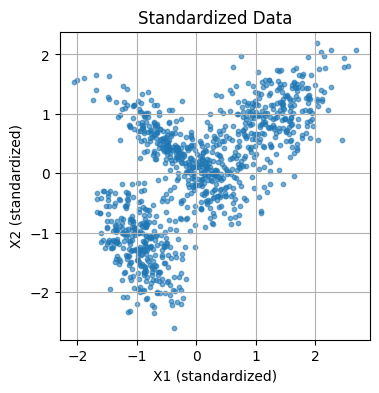

In [2]:
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
data_std = scaler.fit_transform(data)

# Plot the standardized data
plt.figure(figsize=(4, 4))
plt.scatter(data_std[:, 0], data_std[:, 1], s=10, alpha=0.6)
plt.title("Standardized Data")
plt.xlabel("X1 (standardized)")
plt.ylabel("X2 (standardized)")
plt.axis("equal")
plt.grid(True)
plt.show()


This bivariate mixture distribution produces clusters with little overlap. For each data set generated, we fit four finite Gaussian mixtures based on the following prior distributions for component means:
1. M1 - independent gaussian prior (no repulsion)
2. M2 - Ogata and Tanemura-style (1981,1985) repulsion
3. M3 - Petralia Et. Al (2012) repulsion
4. M4 - Hard-core repulsion, additional potential mentioned in Ogata & Tanemura (1981,1985)

### M1: Independent Guassian prior (no repulsion)

In [3]:
from scipy.stats import invwishart, dirichlet, multivariate_normal
from sklearn.preprocessing import StandardScaler


def run_gibbs_m1(data, K, iters, burn_in):
    n, d = data.shape

    # Priors
    mu0 = np.zeros(d)
    Sigma0 = np.eye(d)
    nu = d + 4
    Psi = np.diag([3, 2])
    alpha = np.ones(K)

    # Initialize
    z = np.random.choice(K, size=n)
    pi = np.ones(K) / K
    theta = np.random.multivariate_normal(mu0, Sigma0, size=K)
    Lambda = np.array([invwishart.rvs(df=nu, scale=Psi) for _ in range(K)])

    # Storage
    samples = {"z": [], "theta": [], "pi": [], "Lambda": []}

    for it in range(iters):
        # Step 1: Sample z
        probs = np.zeros((n, K))
        for k in range(K):
            probs[:, k] = pi[k] * multivariate_normal.pdf(data, mean=theta[k], cov=Lambda[k])
        probs /= probs.sum(axis=1, keepdims=True)
        z = np.array([np.random.choice(K, p=probs[i]) for i in range(n)])

        # Step 2: Sample pi
        counts = np.array([np.sum(z == k) for k in range(K)])
        pi = dirichlet.rvs(alpha + counts)[0]

        # Step 3: Sample theta
        for k in range(K):
            nk = counts[k]
            if nk > 0:
                yk = data[z == k]
                Lambda_inv = np.linalg.inv(Lambda[k])
                Sigma_n = np.linalg.inv(np.linalg.inv(Sigma0) + nk * Lambda_inv)
                mu_n = Sigma_n @ (np.linalg.inv(Sigma0) @ mu0 + Lambda_inv @ yk.sum(axis=0))
                theta[k] = np.random.multivariate_normal(mu_n, Sigma_n)
            else:
                theta[k] = np.random.multivariate_normal(mu0, Sigma0)

        # Step 4: Sample Lambda
        for k in range(K):
            yk = data[z == k]
            S = np.sum([(y - theta[k]).reshape(-1, 1) @ (y - theta[k]).reshape(1, -1) for y in yk], axis=0) if len(yk) > 0 else np.zeros((d, d))
            Lambda[k] = invwishart.rvs(df=nu + len(yk), scale=Psi + S)

        # Save post-burn-in samples
        if it >= burn_in:
            samples["z"].append(z.copy())
            samples["theta"].append(theta.copy())
            samples["pi"].append(pi.copy())
            samples["Lambda"].append(Lambda.copy())

        if it % 10 == 0:
            print(f"Iteration {it}/{iters}")

    return samples

# Run the Gibbs sampler with official simulation study settings
samples = run_gibbs_m1(
    data_std,
    4,          
    12000,     # Total iterations = 10,000 burn-in + 2,000 for thinning
    10000    # Discard first 10,000 as burn-in
)

# After running, thin the post-burn-in samples by 2
thinned_samples = {
    "z": samples["z"][::2],
    "theta": samples["theta"][::2],
    "pi": samples["pi"][::2],
    "Lambda": samples["Lambda"][::2]
}



Iteration 0/12000
Iteration 10/12000
Iteration 20/12000
Iteration 30/12000
Iteration 40/12000
Iteration 50/12000
Iteration 60/12000
Iteration 70/12000
Iteration 80/12000
Iteration 90/12000
Iteration 100/12000
Iteration 110/12000
Iteration 120/12000
Iteration 130/12000
Iteration 140/12000
Iteration 150/12000
Iteration 160/12000
Iteration 170/12000
Iteration 180/12000
Iteration 190/12000
Iteration 200/12000
Iteration 210/12000
Iteration 220/12000
Iteration 230/12000
Iteration 240/12000
Iteration 250/12000
Iteration 260/12000
Iteration 270/12000
Iteration 280/12000
Iteration 290/12000
Iteration 300/12000
Iteration 310/12000
Iteration 320/12000
Iteration 330/12000
Iteration 340/12000
Iteration 350/12000
Iteration 360/12000
Iteration 370/12000
Iteration 380/12000
Iteration 390/12000
Iteration 400/12000
Iteration 410/12000
Iteration 420/12000
Iteration 430/12000
Iteration 440/12000
Iteration 450/12000
Iteration 460/12000
Iteration 470/12000
Iteration 480/12000
Iteration 490/12000
Iteration 5

### M2: Ogata & Tanemura: Potential described in Ogata and Tanemura (1981, 1985).

In [4]:
def repulsive_ratio(theta_new, theta_old, theta_others, Sigma_inv, tau):
    def phi(θ, θj):
        diff = θ - θj
        return 1 - np.exp(-0.5 * diff.T @ Sigma_inv @ diff / tau)
    
    def total_phi(θ, others):
        return np.prod([phi(θ, other) for other in others])

    ratio = total_phi(theta_new, theta_others) / total_phi(theta_old, theta_others)
    return ratio


def run_gibbs_m2(data, K, iters, burn_in, tau):
    n, d = data.shape

    # Priors
    mu0 = np.zeros(d)
    Sigma0 = np.eye(d)
    nu = d + 4
    Psi = np.diag([3, 2])
    alpha = np.ones(K)

    # Initialize
    z = np.random.choice(K, size=n)
    pi = np.ones(K) / K
    theta = np.random.multivariate_normal(mu0, Sigma0, size=K)
    Lambda = np.array([invwishart.rvs(df=nu, scale=Psi) for _ in range(K)])

    # Storage
    samples = {"z": [], "theta": [], "pi": [], "Lambda": []}

    for it in range(iters):
        # Step 1: Sample z
        probs = np.zeros((n, K))
        for k in range(K):
            probs[:, k] = pi[k] * multivariate_normal.pdf(data, mean=theta[k], cov=Lambda[k])
        probs /= probs.sum(axis=1, keepdims=True)
        z = np.array([np.random.choice(K, p=probs[i]) for i in range(n)])

        # Step 2: Sample pi 
        counts = np.array([np.sum(z == k) for k in range(K)])
        pi = dirichlet.rvs(alpha + counts)[0]

        # Step 3: Sample theta 
        for j in range(K):
            nk = counts[j]
            yj = data[z == j]
            
            # Posterior parameters from likelihood and prior
            Lambda_inv = np.linalg.inv(Lambda[j])
            Sigma_post = np.linalg.inv(np.linalg.inv(Sigma0) + nk * Lambda_inv)
            mu_post = Sigma_post @ (np.linalg.inv(Sigma0) @ mu0 + Lambda_inv @ yj.sum(axis=0)) if nk > 0 else mu0

            # Proposal: Random walk (can also use Sigma_post directly)
            theta_proposal = np.random.multivariate_normal(theta[j], Sigma_post)

            # MH acceptance ratio
            theta_others = np.delete(theta, j, axis=0)
            num = multivariate_normal.pdf(theta_proposal, mean=mu_post, cov=Sigma_post)
            den = multivariate_normal.pdf(theta[j], mean=mu_post, cov=Sigma_post)
            repulsion = repulsive_ratio(theta_proposal, theta[j], theta_others, np.linalg.inv(Sigma0), tau)

            alpha = min(1, (num / den) * repulsion)

            if np.random.rand() < alpha:
                theta[j] = theta_proposal  # Accept
            # else keep old theta[j]

        # Step 4: Sample Lambda 
        for k in range(K):
            yk = data[z == k]
            S = np.sum([(y - theta[k]).reshape(-1, 1) @ (y - theta[k]).reshape(1, -1) for y in yk], axis=0) if len(yk) > 0 else np.zeros((d, d))
            Lambda[k] = invwishart.rvs(df=nu + len(yk), scale=Psi + S)

        # Save post-burn-in samples
        if it >= burn_in:
            samples["z"].append(z.copy())
            samples["theta"].append(theta.copy())
            samples["pi"].append(pi.copy())
            samples["Lambda"].append(Lambda.copy())

        if it % 10 == 0:
            print(f"Iteration {it}/{iters}")

    return samples

# Run the Gibbs sampler with official simulation study settings
samples_m2 = run_gibbs_m2(
    data_std,
    7,             
    12000,     # Total iterations = 10,000 burn-in + 2,000 for thinning
    10000,
    0.1        # Discard first 10,000 as burn-in
)

# After running, thin the post-burn-in samples by 2
thinned_samples = {
    "z": samples_m2["z"][::2],
    "theta": samples_m2["theta"][::2],
    "pi": samples_m2["pi"][::2],
    "Lambda": samples_m2["Lambda"][::2]
}

Iteration 0/12000
Iteration 10/12000
Iteration 20/12000
Iteration 30/12000
Iteration 40/12000
Iteration 50/12000
Iteration 60/12000
Iteration 70/12000
Iteration 80/12000
Iteration 90/12000
Iteration 100/12000
Iteration 110/12000
Iteration 120/12000
Iteration 130/12000
Iteration 140/12000
Iteration 150/12000
Iteration 160/12000
Iteration 170/12000
Iteration 180/12000
Iteration 190/12000
Iteration 200/12000
Iteration 210/12000
Iteration 220/12000
Iteration 230/12000
Iteration 240/12000
Iteration 250/12000
Iteration 260/12000
Iteration 270/12000
Iteration 280/12000
Iteration 290/12000
Iteration 300/12000
Iteration 310/12000
Iteration 320/12000
Iteration 330/12000
Iteration 340/12000
Iteration 350/12000
Iteration 360/12000
Iteration 370/12000
Iteration 380/12000
Iteration 390/12000
Iteration 400/12000
Iteration 410/12000
Iteration 420/12000
Iteration 430/12000
Iteration 440/12000
Iteration 450/12000
Iteration 460/12000
Iteration 470/12000
Iteration 480/12000
Iteration 490/12000
Iteration 5

### M3

In [5]:
def repulsive_ratio_m3(theta_new, theta_old, theta_others, tau):
    def phi(θ, θj):
        dist = np.linalg.norm(θ - θj)
        return np.exp(-tau * (1 / (dist ** 2 + 1e-8)))  # +1e-8 avoids division by zero
    
    def total_phi(θ, others):
        return np.prod([phi(θ, other) for other in others])
    
    numerator = total_phi(theta_new, theta_others)
    denominator = total_phi(theta_old, theta_others)
    return numerator / denominator if denominator > 0 else 1.0

def run_gibbs_m3(data, K=7, iters=200, burn_in=50, tau=0.1):
    n, d = data.shape

    # Priors
    mu0 = np.zeros(d)
    Sigma0 = np.eye(d)
    Sigma0_inv = np.linalg.inv(Sigma0)
    nu = d + 4
    Psi = np.diag([3, 2])
    alpha = np.ones(K)

    # Initialize
    z = np.random.choice(K, size=n)
    pi = np.ones(K) / K
    theta = np.random.multivariate_normal(mu0, Sigma0, size=K)
    Lambda = np.array([invwishart.rvs(df=nu, scale=Psi) for _ in range(K)])

    # Storage
    samples = {"z": [], "theta": [], "pi": [], "Lambda": []}

    for it in range(iters):
        # Step 1: Update z
        probs = np.zeros((n, K))
        for k in range(K):
            probs[:, k] = pi[k] * multivariate_normal.pdf(data, mean=theta[k], cov=Lambda[k])
        probs /= probs.sum(axis=1, keepdims=True)
        z = np.array([np.random.choice(K, p=probs[i]) for i in range(n)])

        # Step 2: Update pi
        counts = np.array([np.sum(z == k) for k in range(K)])
        pi = dirichlet.rvs(alpha + counts)[0]

        # Step 3: Metropolis–Hastings for theta with M3 repulsion
        for j in range(K):
            nk = counts[j]
            yj = data[z == j]
            Lambda_inv = np.linalg.inv(Lambda[j])
            Sigma_post = np.linalg.inv(Sigma0_inv + nk * Lambda_inv)
            mu_post = Sigma_post @ (Sigma0_inv @ mu0 + Lambda_inv @ yj.sum(axis=0)) if nk > 0 else mu0

            theta_prop = np.random.multivariate_normal(theta[j], Sigma_post)
            theta_others = np.delete(theta, j, axis=0)

            num = multivariate_normal.pdf(theta_prop, mean=mu_post, cov=Sigma_post)
            den = multivariate_normal.pdf(theta[j], mean=mu_post, cov=Sigma_post)
            repulse = repulsive_ratio_m3(theta_prop, theta[j], theta_others, tau)
            alpha_mh = min(1, (num / den) * repulse)

            if np.random.rand() < alpha_mh:
                theta[j] = theta_prop

        # Step 4: Update Lambda
        for k in range(K):
            yk = data[z == k]
            S = np.sum([(y - theta[k]).reshape(-1, 1) @ (y - theta[k]).reshape(1, -1) for y in yk], axis=0) if len(yk) > 0 else np.zeros((d, d))
            Lambda[k] = invwishart.rvs(df=nu + len(yk), scale=Psi + S)

        if it >= burn_in:
            samples["z"].append(z.copy())
            samples["theta"].append(theta.copy())
            samples["pi"].append(pi.copy())
            samples["Lambda"].append(Lambda.copy())

        if it % 10 == 0:
            print(f"[M3] Iteration {it}/{iters}")

    return samples

samples_m3 = run_gibbs_m3(
    data_std,
    7,             
    12000,     # Total iterations = 10,000 burn-in + 2,000 for thinning
    10000,
    0.1        # Discard first 10,000 as burn-in
)

# After running, thin the post-burn-in samples by 2
thinned_samples = {
    "z": samples_m3["z"][::2],
    "theta": samples_m3["theta"][::2],
    "pi": samples_m3["pi"][::2],
    "Lambda": samples_m3["Lambda"][::2]
}

[M3] Iteration 0/12000
[M3] Iteration 10/12000
[M3] Iteration 20/12000
[M3] Iteration 30/12000
[M3] Iteration 40/12000
[M3] Iteration 50/12000
[M3] Iteration 60/12000
[M3] Iteration 70/12000
[M3] Iteration 80/12000
[M3] Iteration 90/12000
[M3] Iteration 100/12000
[M3] Iteration 110/12000
[M3] Iteration 120/12000
[M3] Iteration 130/12000
[M3] Iteration 140/12000
[M3] Iteration 150/12000
[M3] Iteration 160/12000
[M3] Iteration 170/12000
[M3] Iteration 180/12000
[M3] Iteration 190/12000
[M3] Iteration 200/12000
[M3] Iteration 210/12000
[M3] Iteration 220/12000
[M3] Iteration 230/12000
[M3] Iteration 240/12000
[M3] Iteration 250/12000
[M3] Iteration 260/12000
[M3] Iteration 270/12000
[M3] Iteration 280/12000
[M3] Iteration 290/12000
[M3] Iteration 300/12000
[M3] Iteration 310/12000
[M3] Iteration 320/12000
[M3] Iteration 330/12000
[M3] Iteration 340/12000
[M3] Iteration 350/12000
[M3] Iteration 360/12000
[M3] Iteration 370/12000
[M3] Iteration 380/12000
[M3] Iteration 390/12000
[M3] Iterat

### M4


In [6]:
def repulsive_accept_m4(theta_prop, theta_others, tau):
    for other in theta_others:
        dist = np.linalg.norm(theta_prop - other)
        if dist <= tau:
            return False  # reject if any other center is too close
    return True  # all pairwise distances > tau


def run_gibbs_m4(data, K=7, iters=200, burn_in=50, tau=0.1):
    n, d = data.shape

    mu0 = np.zeros(d)
    Sigma0 = np.eye(d)
    Sigma0_inv = np.linalg.inv(Sigma0)
    nu = d + 4
    Psi = np.diag([3, 2])
    alpha = np.ones(K)

    z = np.random.choice(K, size=n)
    pi = np.ones(K) / K
    theta = np.random.multivariate_normal(mu0, Sigma0, size=K)
    Lambda = np.array([invwishart.rvs(df=nu, scale=Psi) for _ in range(K)])

    samples = {"z": [], "theta": [], "pi": [], "Lambda": []}

    for it in range(iters):
        # Step 1: Update z
        probs = np.zeros((n, K))
        for k in range(K):
            probs[:, k] = pi[k] * multivariate_normal.pdf(data, mean=theta[k], cov=Lambda[k])
        probs /= probs.sum(axis=1, keepdims=True)
        z = np.array([np.random.choice(K, p=probs[i]) for i in range(n)])

        # Step 2: Update pi
        counts = np.array([np.sum(z == k) for k in range(K)])
        pi = dirichlet.rvs(alpha + counts)[0]

        # Step 3: MH update for θ with hard-core repulsion
        for j in range(K):
            nk = counts[j]
            yj = data[z == j]
            Lambda_inv = np.linalg.inv(Lambda[j])
            Sigma_post = np.linalg.inv(Sigma0_inv + nk * Lambda_inv)
            mu_post = Sigma_post @ (Sigma0_inv @ mu0 + Lambda_inv @ yj.sum(axis=0)) if nk > 0 else mu0

            theta_prop = np.random.multivariate_normal(theta[j], Sigma_post)
            theta_others = np.delete(theta, j, axis=0)

            # Only accept if all distances > tau
            accept = repulsive_accept_m4(theta_prop, theta_others, tau)
            if accept:
                theta[j] = theta_prop  # accept
            # else reject (keep old theta[j])

        # Step 4: Update Lambda
        for k in range(K):
            yk = data[z == k]
            S = np.sum([(y - theta[k]).reshape(-1, 1) @ (y - theta[k]).reshape(1, -1) for y in yk], axis=0) if len(yk) > 0 else np.zeros((d, d))
            Lambda[k] = invwishart.rvs(df=nu + len(yk), scale=Psi + S)

        if it >= burn_in:
            samples["z"].append(z.copy())
            samples["theta"].append(theta.copy())
            samples["pi"].append(pi.copy())
            samples["Lambda"].append(Lambda.copy())

        if it % 10 == 0:
            print(f"[M4] Iteration {it}/{iters}")

    return samples


samples_m4 = run_gibbs_m3(
    data_std,
    7,             # You can change this to 4 or 10 later
    12000,     # Total iterations = 10,000 burn-in + 2,000 for thinning
    10000,
    0.1        # Discard first 10,000 as burn-in
)

# After running, thin the post-burn-in samples by 2
thinned_samples = {
    "z": samples_m4["z"][::2],
    "theta": samples_m4["theta"][::2],
    "pi": samples_m4["pi"][::2],
    "Lambda": samples_m4["Lambda"][::2]
}


[M3] Iteration 0/12000
[M3] Iteration 10/12000
[M3] Iteration 20/12000
[M3] Iteration 30/12000
[M3] Iteration 40/12000
[M3] Iteration 50/12000
[M3] Iteration 60/12000
[M3] Iteration 70/12000
[M3] Iteration 80/12000
[M3] Iteration 90/12000
[M3] Iteration 100/12000
[M3] Iteration 110/12000
[M3] Iteration 120/12000
[M3] Iteration 130/12000
[M3] Iteration 140/12000
[M3] Iteration 150/12000
[M3] Iteration 160/12000
[M3] Iteration 170/12000
[M3] Iteration 180/12000
[M3] Iteration 190/12000
[M3] Iteration 200/12000
[M3] Iteration 210/12000
[M3] Iteration 220/12000
[M3] Iteration 230/12000
[M3] Iteration 240/12000
[M3] Iteration 250/12000
[M3] Iteration 260/12000
[M3] Iteration 270/12000
[M3] Iteration 280/12000
[M3] Iteration 290/12000
[M3] Iteration 300/12000
[M3] Iteration 310/12000
[M3] Iteration 320/12000
[M3] Iteration 330/12000
[M3] Iteration 340/12000
[M3] Iteration 350/12000
[M3] Iteration 360/12000
[M3] Iteration 370/12000
[M3] Iteration 380/12000
[M3] Iteration 390/12000
[M3] Iterat

### Fig. 2

In [7]:
def compute_lpml(data, samples):
    """Compute LPML given posterior samples from a model."""
    S = len(samples["theta"])
    n = data.shape[0]
    cpo_inv = np.zeros(n)

    for i in range(n):
        # For each observation, average likelihood over all samples
        liks = []
        for s in range(S):
            theta = samples["theta"][s]
            Lambda = samples["Lambda"][s]
            pi = samples["pi"][s]
            p = 0
            for k in range(len(pi)):
                p += pi[k] * multivariate_normal.pdf(data[i], mean=theta[k], cov=Lambda[k])
            liks.append(1 / (p + 1e-10))  # Add small constant to avoid division by zero
        cpo_inv[i] = np.mean(liks)

    lpml = -np.sum(np.log(cpo_inv + 1e-10))  # Add small constant for numerical safety
    return lpml
